# Regresión logística para predicciones bancarias

## CARGAMOS NUESTROS MÓDULOS

In [5]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
import statsmodels.api as sm
import math

# Para un modelo supervisado de ejemplo
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier

## Métricas de los modelos para evaluar los modelos
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

## CARGAMOS NUESTRAS FUNCIONES

In [7]:
def encontrar_outliers(data,col):
    outliers=[]
    Q1=data[col].quantile(0.25)
    Q3=data[col].quantile(0.75)
    IQR=Q3-Q1
    lower_limit=Q1-(1.5*IQR)
    upper_limit=Q3+(1.5*IQR)
    for out1 in data[col]:
        if out1>upper_limit or out1<lower_limit:
            outliers.append(out1)
    return np.array(outliers)

def graficos(data,col):
    fix,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    sns.boxplot(y=data[col],ax=ax1)
    ax1.set_ylabel=col
    ax1.set_title('Gráfico de cajas de {}'.format(col))
    sns.histplot(data,x=col,kde=True,ax=ax2)
    ax2.set_title('Distribution plot of {}'.format(col))
    plt.axvline(data[col].mean(),color='red',linestyle='--')
    plt.legend(['densidad','media','distribución'])

def analisis_numerico(data,col):
    print('Cantidad de outlier:',len(encontrar_outliers(data,col)))
    print('Media:',round(data[col].mean(),3))
    print('Mediana:',data[col].median())
    print('Q1:',data[col].quantile(0.25))
    print('Q3:',data[col].quantile(0.75))
    print('max:',data[col].max())
    print('Asimetría:',round(sp.skew(data[col]),3))
    print('Kurtosis:',round(sp.kurtosis(data[col].max()),3))
    graficos(data,col)

def topcorrelaciones(data):
    cormatrix = data.corr()
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    cormatrix.columns = ["Variable 1", "Variable 2", "correlación"]
    cormatrix=cormatrix.query('correlación!=0')
    return cormatrix

def describe_dataframe(df):
        column_descriptions = []

        for column in df.columns:
            #print(column)
            column_info = {}
            column_info['variable'] = column

            # Calcular el porcentaje de valores nulos
            null_percentage = df[column].isnull().mean() * 100
            column_info['nulos'] = round(null_percentage, 2)

            # Determinar el tipo de variable
            unique_values = df[column].nunique()
            total_values = len(df[column])
            if pd.api.types.is_object_dtype(df[column]): #pd.api.types.is_categorical_dtype(df[column]) or pd.api.types.is_string_dtype(df[column]) or
                column_info['tipo'] = 'Categorical'
                column_info['etiquetas'] = unique_values
            elif pd.api.types.is_numeric_dtype(df[column]):
                if unique_values / total_values < 0.1:
                # if unique_values < 30:
                    column_info['tipo'] = 'Discrete'
                    column_info['etiquetas'] = unique_values
                else:
                    column_info['tipo'] = 'Continuous'
                    column_info['etiquetas'] = 'N/A'  # No aplicable para variables continuas
            else:
                column_info['tipo'] = 'Other'
                column_info['etiquetas'] = 'N/A'  # No aplicable para otras variables

            # Verificar la presencia de outliers (solo para variables numéricas)
            if pd.api.types.is_numeric_dtype(df[column]):
                q1 = df[column].quantile(0.25)
                q3 = df[column].quantile(0.85)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
                column_info['outliers'] = 'Yes' if outliers > 0 else 'No'
            else:
                column_info['outliers'] = 'N/A'  # No aplicable para variables no numéricas

            column_descriptions.append(column_info)

        return pd.DataFrame(column_descriptions)

## Cargadar Datos

In [8]:
data = pd.read_csv(r"G:\OneDrive - Universidad Tecnologica del Peru\Estudios\Cursos\Analisis de Datos\Universidad Ricardo Palma\ESTADISTICA CON PYTHON\codigo\base de datos\bank.csv", sep=";")

In [9]:
# y es la variable tarjet o objetivo (ultima columna)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [10]:
#4119 filas, 21 columnas
data.shape

(4119, 21)

In [11]:
data.columns.values

array(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'], dtype=object)

y
no     3668
yes     451
Name: count, dtype: int64


<Axes: xlabel='count', ylabel='y'>

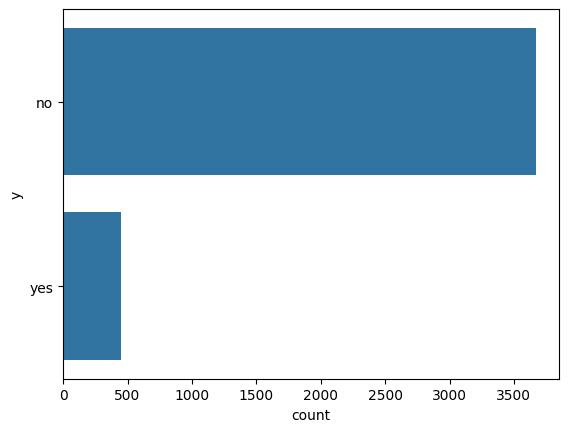

In [12]:
print(data.y.value_counts())
sns.countplot(y='y', data=data)

In [13]:
#transformar el "no" y "si" por 0 y 1 respectivamente y trasfomar de booleano a entero
data["y"] = (data["y"]=="yes").astype(int)
print(data.y.value_counts())

y
0    3668
1     451
Name: count, dtype: int64


In [14]:
#visualizar los ultimos registros
data.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
4114,30,admin.,married,basic.6y,no,yes,yes,cellular,jul,thu,53,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,0
4115,39,admin.,married,high.school,no,yes,no,telephone,jul,fri,219,1,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,0
4116,27,student,single,high.school,no,no,no,cellular,may,mon,64,2,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,0
4117,58,admin.,married,high.school,no,no,no,cellular,aug,fri,528,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,0
4118,34,management,single,high.school,no,yes,no,cellular,nov,wed,175,1,999,0,nonexistent,-0.1,93.200,-42.0,4.120,5195.8,0


In [15]:
var_ = describe_dataframe(data)
var_

,variable,nulos,tipo,etiquetas,outliers
0,age,0.0,Discrete,67,Yes
1,job,0.0,Categorical,12,N/A
2,marital,0.0,Categorical,4,N/A
3,education,0.0,Categorical,8,N/A
4,default,0.0,Categorical,3,N/A
5,housing,0.0,Categorical,3,N/A
6,loan,0.0,Categorical,3,N/A
7,contact,0.0,Categorical,2,N/A
8,month,0.0,Categorical,10,N/A
9,day_of_week,0.0,Categorical,5,N/A


## Exploración de Variables Categóricas

In [16]:
#filtrar datos categoricos
var_[var_["tipo"]=="Categorical"]

,variable,nulos,tipo,etiquetas,outliers
1,job,0.0,Categorical,12,N/A
2,marital,0.0,Categorical,4,N/A
3,education,0.0,Categorical,8,N/A
4,default,0.0,Categorical,3,N/A
5,housing,0.0,Categorical,3,N/A
6,loan,0.0,Categorical,3,N/A
7,contact,0.0,Categorical,2,N/A
8,month,0.0,Categorical,10,N/A
9,day_of_week,0.0,Categorical,5,N/A
14,poutcome,0.0,Categorical,3,N/A


In [17]:
#filtrar datos categoricos, y colocarlos en una lista
l_categorico = var_[var_["tipo"]=="Categorical"].variable.to_list()
l_categorico

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

<Axes: xlabel='count', ylabel='job'>

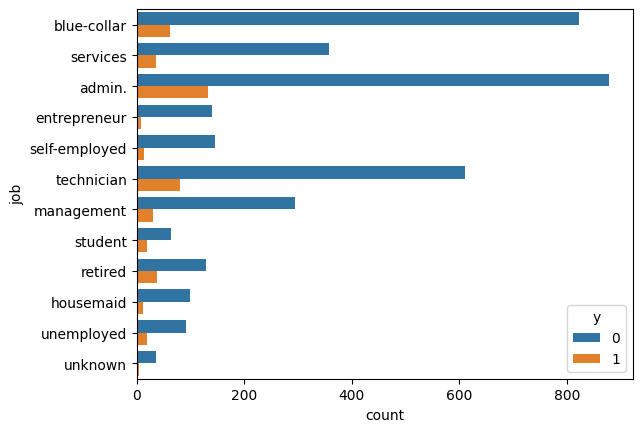

In [18]:
sns.countplot(y='job',hue='y',data=data)

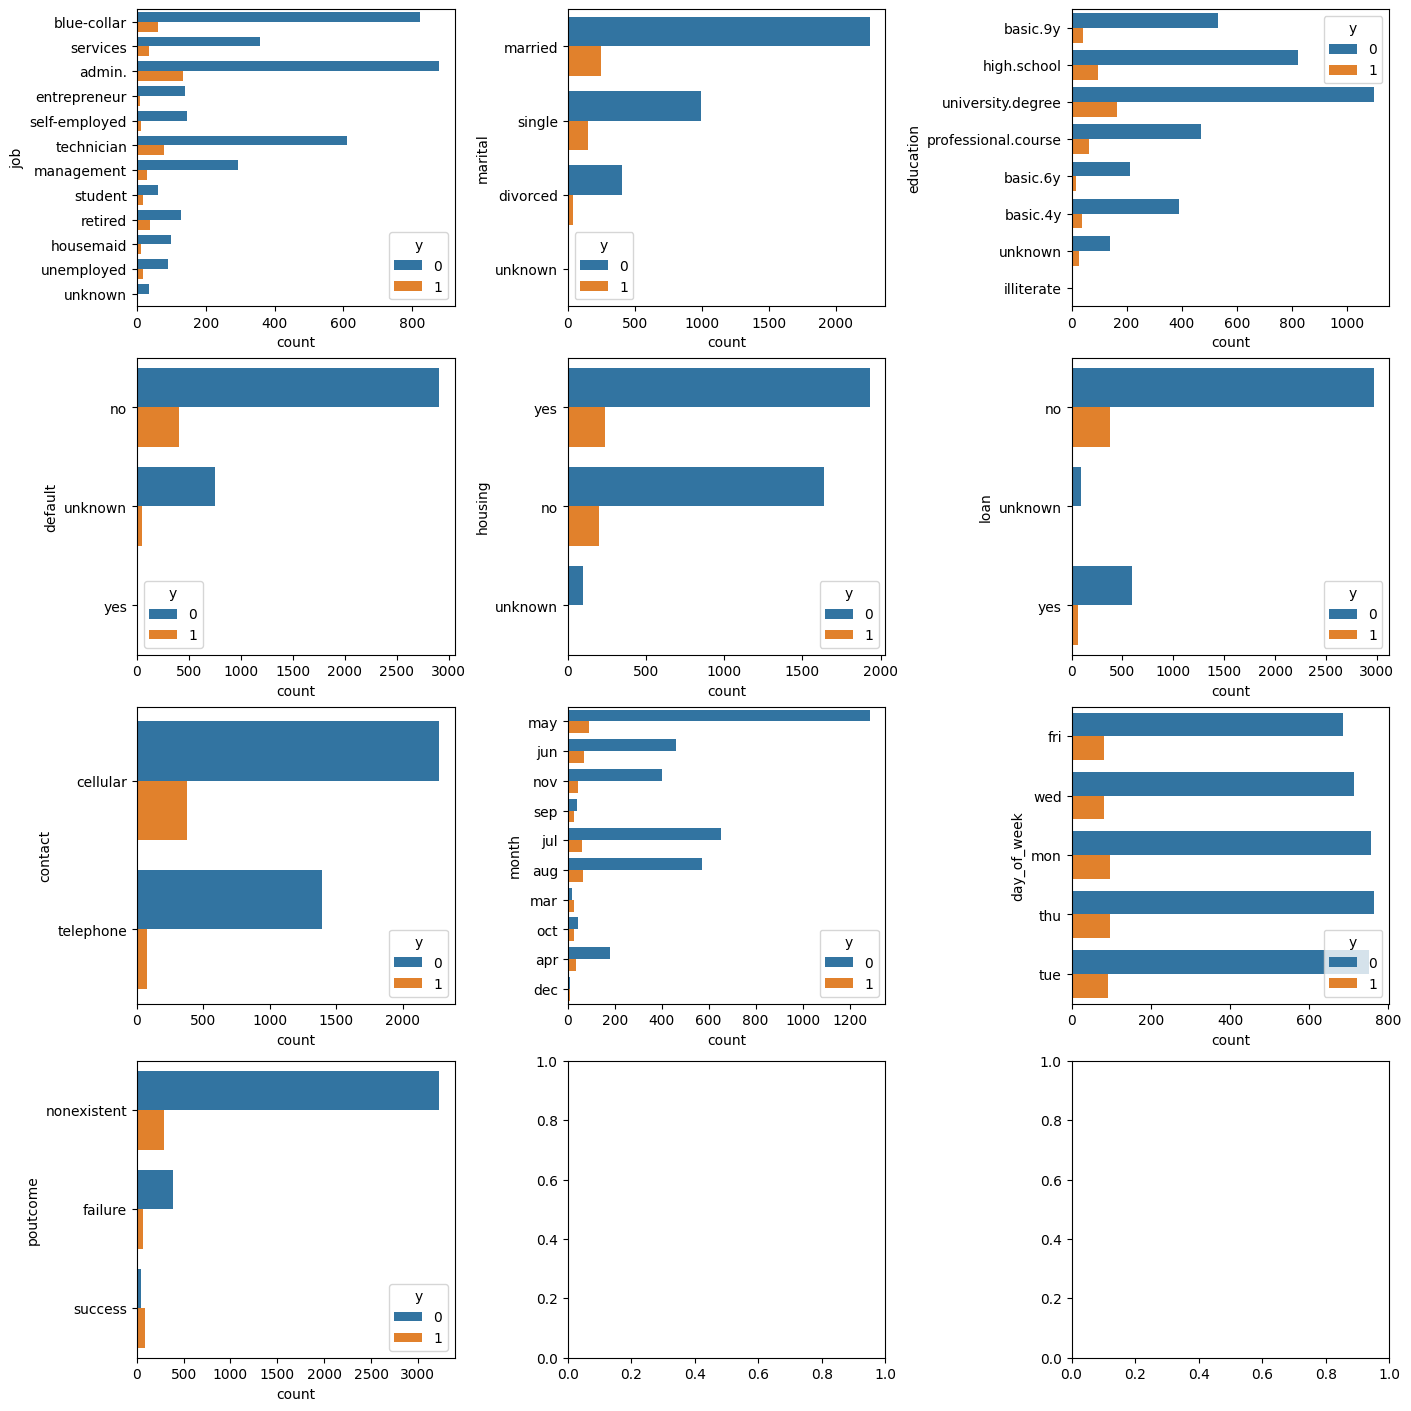

In [19]:
c=3
r=math.ceil(len(l_categorico)/c)
fig, ax = plt.subplots(r,c,figsize=(14, 14),constrained_layout=True)
for i,j in zip(l_categorico,ax.ravel()):
    axx=sns.countplot(y=i, hue='y',data=data,ax=j) #, hue='y'

In [20]:
#visualizar todas las etiquetas de la variable education
data["education"].unique()

array(['basic.9y', 'high.school', 'university.degree',
       'professional.course', 'basic.6y', 'basic.4y', 'unknown',
       'illiterate'], dtype=object)

In [21]:
#uniendo etiquetas similares, ejm: basic.4, basic.6, basic.9 en una sola variable
data["education"] = np.where(data["education"]=="basic.4y", "Basic", data["education"])
data["education"] = np.where(data["education"]=="basic.6y", "Basic", data["education"])
data["education"] = np.where(data["education"]=="basic.9y", "Basic", data["education"])

data["education"] = np.where(data["education"]=="high.school", "High School", data["education"])
data["education"] = np.where(data["education"]=="professional.course", "Professional Course", data["education"])
data["education"] = np.where(data["education"]=="university.degree", "University Degree", data["education"])

data["education"] = np.where(data["education"]=="illiterate", "Illiterate", data["education"])
data["education"] = np.where(data["education"]=="unknown", "Unknown", data["education"])

In [22]:
#visualizando las etiquetas cambiadas:
data["education"].unique()

array(['Basic', 'High School', 'University Degree', 'Professional Course',
       'Unknown', 'Illiterate'], dtype=object)

In [23]:
#visualizar las variables que no son categoricas, como son: numericas, discretas, continuas
l_otros = var_[var_["tipo"]!="Categorical"].variable.to_list()
l_otros

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y']

In [24]:
#analizar la media (promedio) de todas las variables numericas con respecto a la variable objetivo "y"
data.groupby("y")[l_otros].mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
y,,,,,,,,,,,
0,39.895311,219.40976,2.605780,982.763086,0.141767,0.240185,93.599677,-40.586723,3.802826,5175.502072,0.0
1,41.889135,560.78714,1.980044,778.722838,0.585366,-1.177384,93.417268,-39.786475,2.145448,5093.118625,1.0


In [25]:
#analizar la media (promedio) de todas las variables numericas con respecto a la variable objetivo "education"
data.groupby("education")[l_otros].mean()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
education,,,,,,,,,,,
Basic,42.337124,253.898457,2.429732,978.815597,0.149472,0.237368,93.658600,-41.120552,3.775701,5174.133144,0.079610
High School,38.097720,258.534202,2.630836,958.022801,0.206298,-0.002497,93.564314,-40.995765,3.511732,5163.212595,0.105320
Illiterate,42.000000,146.000000,4.000000,999.000000,0.000000,-2.900000,92.201000,-31.400000,0.834000,5076.200000,0.000000
Professional Course,40.207477,278.816822,2.512150,958.211215,0.194393,0.163925,93.599630,-40.127664,3.701426,5167.595140,0.121495
University Degree,39.017405,247.707278,2.583070,947.900316,0.207278,-0.009731,93.499109,-39.830063,3.547132,5163.023180,0.130538
Unknown,42.826347,267.281437,2.538922,939.700599,0.263473,-0.074251,93.637455,-39.487425,3.410174,5151.260479,0.155689


In [26]:
#hacer un conteo de datos de la varible "education", con respecto a la variable "y"
pd.crosstab(data.education, data.y)

y,0,1
education,,
Basic,1133,98
High School,824,97
Illiterate,1,0
Professional Course,470,65
University Degree,1099,165
Unknown,141,26


Text(0, 0.5, 'Frecuencia de compra del producto')

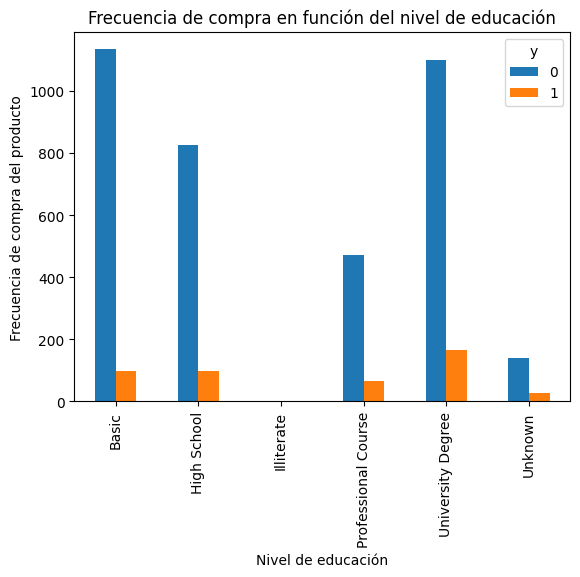

In [27]:
%matplotlib inline
pd.crosstab(data.education, data.y).plot(kind="bar")
plt.title("Frecuencia de compra en función del nivel de educación")
plt.xlabel("Nivel de educación")
plt.ylabel("Frecuencia de compra del producto")

Text(0, 0.5, 'Proporción de clientes')

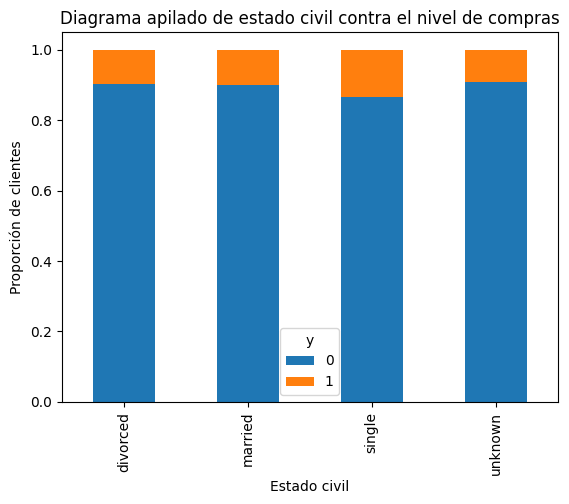

In [28]:
table=pd.crosstab(data.marital, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Diagrama apilado de estado civil contra el nivel de compras")
plt.xlabel("Estado civil")
plt.ylabel("Proporción de clientes")

Text(0, 0.5, 'Frecuencia de compra del producto')

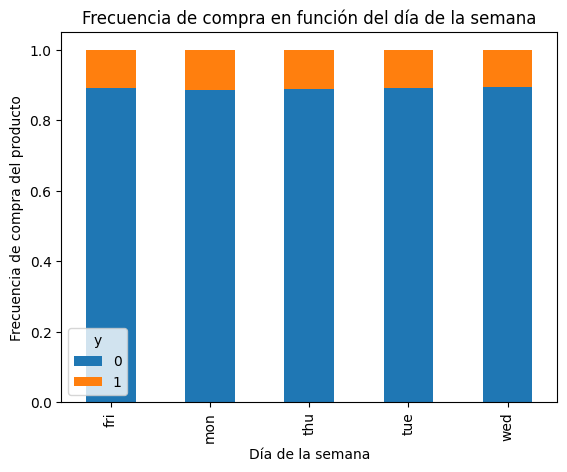

In [29]:
%matplotlib inline
table= pd.crosstab(data.day_of_week, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Frecuencia de compra en función del día de la semana")
plt.xlabel("Día de la semana")
plt.ylabel("Frecuencia de compra del producto")

Text(0, 0.5, 'Frecuencia de compra del producto')

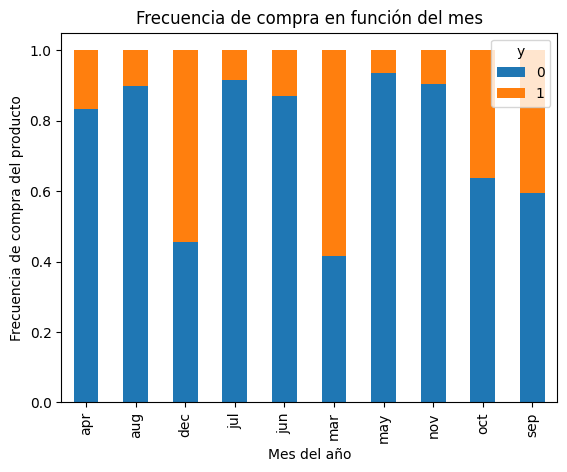

In [30]:
%matplotlib inline
table= pd.crosstab(data.month, data.y)
table.div(table.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
plt.title("Frecuencia de compra en función del mes")
plt.xlabel("Mes del año")
plt.ylabel("Frecuencia de compra del producto")

Text(0, 0.5, 'Frecuencia de compra del producto')

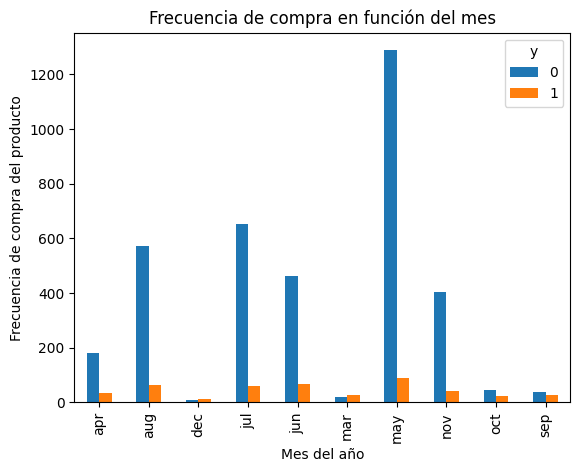

In [31]:
%matplotlib inline
table.plot(kind="bar", stacked=False)
plt.title("Frecuencia de compra en función del mes")
plt.xlabel("Mes del año")
plt.ylabel("Frecuencia de compra del producto")

## Exploración de Variables Numéricas

Cantidad de outlier: 39
Media: 40.114
Mediana: 38.0
Q1: 32.0
Q3: 47.0
max: 88
Asimetría: 0.715
Kurtosis: nan


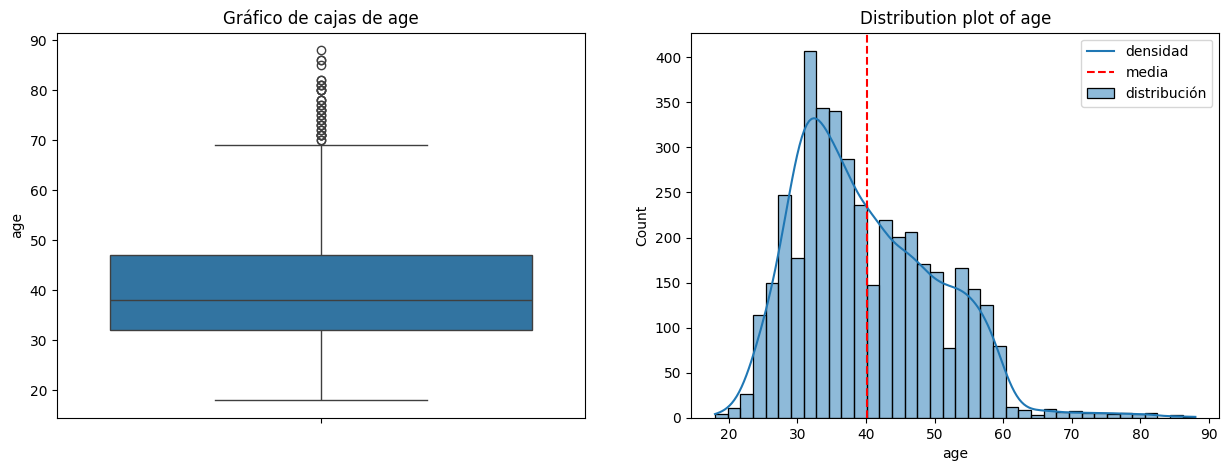

In [32]:
analisis_numerico(data,'age')

Text(0, 0.5, 'Cliente')

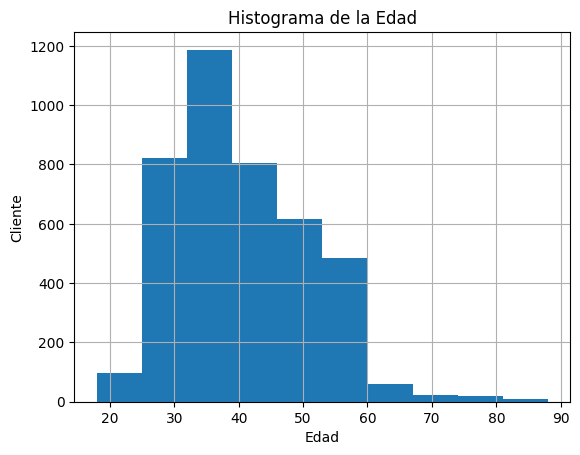

In [33]:
%matplotlib inline
data.age.hist()
plt.title("Histograma de la Edad")
plt.xlabel("Edad")
plt.ylabel("Cliente")

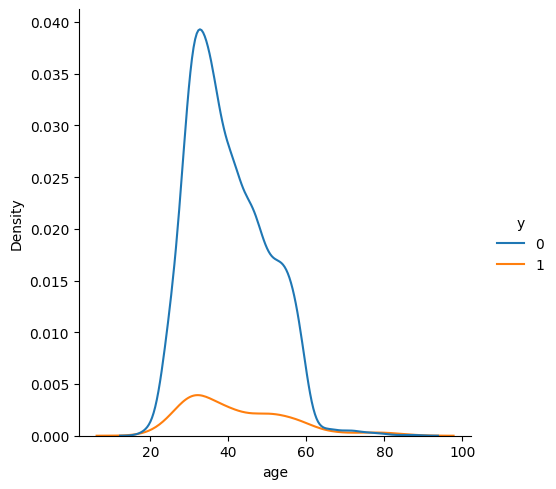

In [34]:
sns.displot(data, x="age", hue="y", kind="kde")

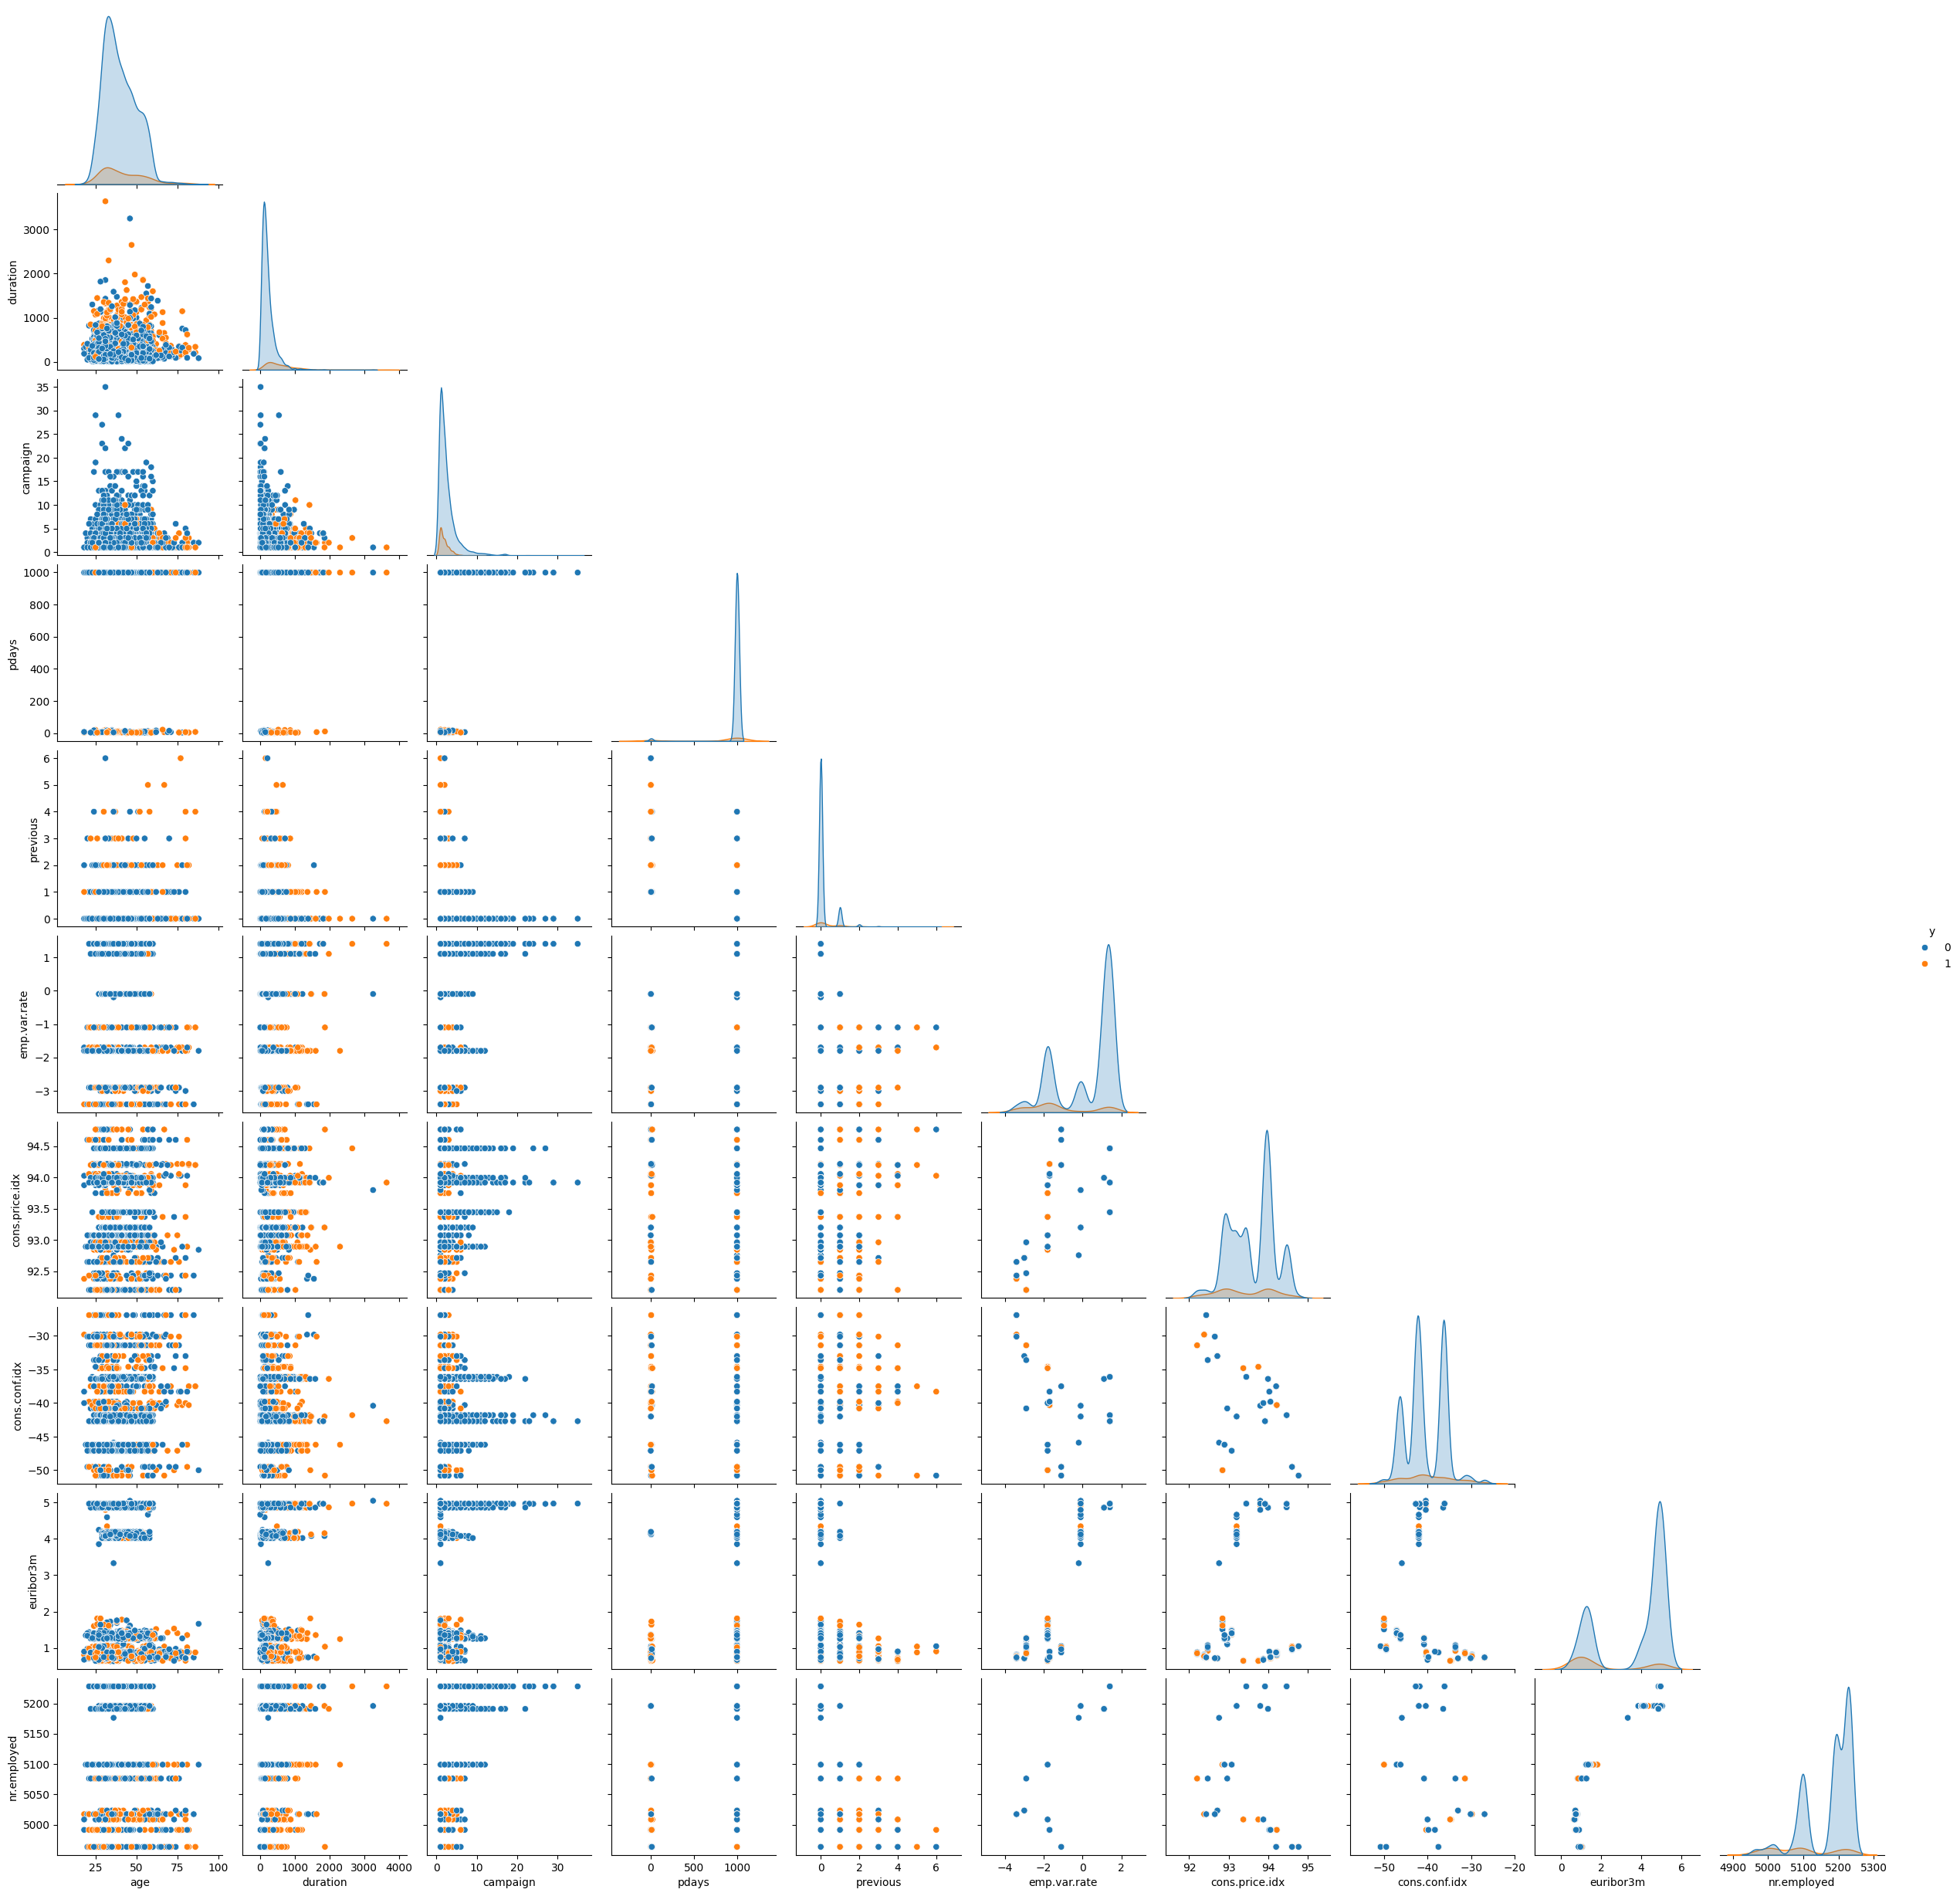

In [35]:
sns.pairplot(data[l_otros], hue="y", diag_kind="kde",  corner=True)

<Axes: >

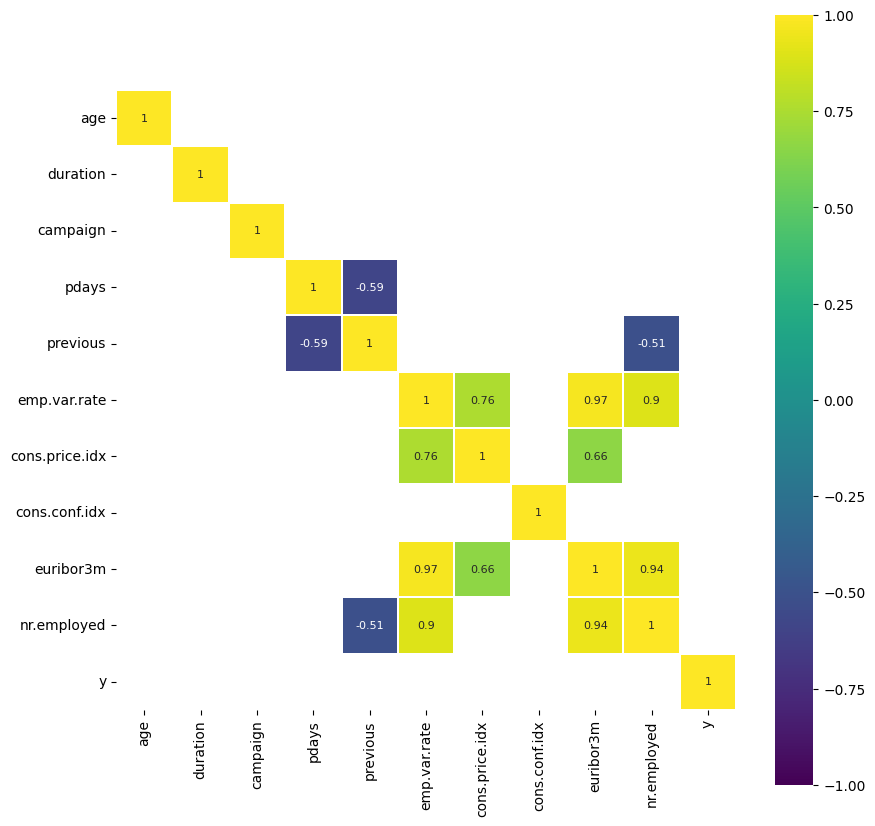

In [36]:
corr = data[l_otros].corr() # We already examined SalePrice correlations para variable numericas o continuas
plt.figure(figsize=(10, 10))
k = 0.5
sns.heatmap(corr[(corr >= k) | (corr <= -k)], #solo considera las correlaciones mayores a k (0.5)
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

### Conversión de las variables categóricas a dummies

In [37]:
#Vamos a generar datos Dummies,por cada variable categorica
categories = ["job", "marital", "education", "housing", "loan", "contact",
              "month", "day_of_week", "poutcome"]
for category in categories:
    cat_list = "cat"+ "_"+category
    cat_dummies = pd.get_dummies(data[category], prefix=category)
    data_new = data.join(cat_dummies)
    data = data_new

In [38]:
data.shape

(4119, 69)

se han creado 69 variables categoricas, si se crean muchas variable dummies puede provocar problemas de dimensionabilidad y afectar el analisis

In [39]:
data_vars = data.columns.values.tolist()

In [40]:
to_keep = [v for v in data_vars if v not in categories]
to_keep = [v for v in to_keep if v not in ["default"]]
to_keep

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'y',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'marital_unknown',
 'education_Basic',
 'education_High School',
 'education_Illiterate',
 'education_Professional Course',
 'education_University Degree',
 'education_Unknown',
 'housing_no',
 'housing_unknown',
 'housing_yes',
 'loan_no',
 'loan_unknown',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'day_of_week_fri',
 'day_of_week_mon',
 'day_of_week_thu',
 'day_of_week_tue',
 'day_of_week_wed',
 'poutcome_failure',

In [41]:
bank_data = data[to_keep]
bank_data.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_Basic', 'education_High School',
       'education_Illiterate', 'education_Professional Course',
       'education_University Degree', 'education_Unknown', 'housing_no',
       'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr',
       'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'd

In [42]:

bank_data_vars = bank_data.columns.values.tolist()
Y = ['y']
X = [v for v in bank_data_vars if v not in Y]

In [43]:
print(Y)
print(X)

['y']
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_Basic', 'education_High School', 'education_Illiterate', 'education_Professional Course', 'education_University Degree', 'education_Unknown', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent', 'poutcome_success']


## Selección de rasgos para el modelo

In [44]:
#quiero solo seleccionar las 12 variables mas relevantes para el modelo
n = 12

In [45]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [46]:
lr = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
lr

LogisticRegression(class_weight='balanced', max_iter=10000)

In [47]:
#va a permitir ir eliminando variables que no aportan mucho al modelo
rfe = RFE(lr, n_features_to_select=12)
rfe = rfe.fit(bank_data[X], bank_data[Y].values.ravel())

In [48]:
print(rfe.support_)

[False False False False False  True  True False False False False False
 False False False False  True False False False False False False False
 False  True False False False False False False False False False False
  True False  True False  True False  True False False  True  True  True
 False False False False False False False False False  True]


In [49]:
print(rfe.ranking_)

[40 46 26 47 15  1  1 33  2 43  7 37 22 28 16  4  1 45 30  6 13 27 21 34
 35  1 32 17 12 23 31 24 20 14 42 25  1 41  1  8  1 38  1 10  3  1  1  1
  9 11 44 39 29 36 18  5 19  1]


In [50]:
z=pd.DataFrame(zip(bank_data_vars,rfe.support_, rfe.ranking_))
z.columns = ["variable", "selected", "rank"]
z

,variable,selected,rank
0,age,False,40
1,duration,False,46
2,campaign,False,26
3,pdays,False,47
4,previous,False,15
5,emp.var.rate,True,1
6,cons.price.idx,True,1
7,cons.conf.idx,False,33
8,euribor3m,False,2
9,nr.employed,False,43


In [51]:
z[z['rank']==1]

,variable,selected,rank
5,emp.var.rate,True,1
6,cons.price.idx,True,1
16,job_retired,True,1
25,marital_single,True,1
36,loan_no,True,1
38,loan_yes,True,1
40,contact_telephone,True,1
42,month_aug,True,1
45,month_jun,True,1
46,month_mar,True,1


In [52]:
cols = ["previous", "euribor3m", "job_retired", "loan_no", "contact_telephone", "month_aug",
        "month_jun", "month_mar", "month_may", "month_nov", "day_of_week_wed", "poutcome_nonexistent"]

In [53]:
X = bank_data[cols].astype(float)
Y = bank_data["y"]

In [54]:
X.head()

,previous,euribor3m,job_retired,loan_no,contact_telephone,month_aug,month_jun,month_mar,month_may,month_nov,day_of_week_wed,poutcome_nonexistent
0,0.0,1.313,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,4.855,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.0,4.962,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.0,4.959,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,4.191,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [55]:
X.shape

(4119, 12)

## Implementación del modelo en Python con scikit-learn

In [56]:
from sklearn import linear_model

In [57]:
logit_model = linear_model.LogisticRegression()
logit_model.fit(X,Y)

LogisticRegression()

In [58]:
logit_model.score(X,Y) #accuracy

0.896091284292304

el accuracy tiene una presicion del 89%, lo cual es atilisimo

In [59]:
1-Y.mean()

0.8905074047098811

In [60]:
#Coeficientes del model 
logit_model.coef_[0]

array([ 0.51165159, -0.48130103,  0.31435908,  0.15378369, -0.27246722,
       -0.04311015,  0.46471761,  1.10765959, -0.95111835, -0.23959723,
        0.12920354,  0.34101992])

In [61]:
t_coeficientes = pd.DataFrame(list(zip(X.columns, np.transpose(logit_model.coef_[0]))))
t_coeficientes.columns = ["variable", "coeficiente"]
t_coeficientes['oddratio (OR)'] = np.exp(t_coeficientes['coeficiente'])
t_coeficientes

,variable,coeficiente,oddratio (OR)
0,previous,0.511652,1.668044
1,euribor3m,-0.481301,0.617979
2,job_retired,0.314359,1.369381
3,loan_no,0.153784,1.166239
4,contact_telephone,-0.272467,0.761498
5,month_aug,-0.043110,0.957806
6,month_jun,0.464718,1.591565
7,month_mar,1.107660,3.027265
8,month_may,-0.951118,0.386309
9,month_nov,-0.239597,0.786945


**Definición básica:**
El OR representa el cambio en las probabilidades del resultado por cada unidad de aumento en la variable predictora.
Interpretación general:

- OR = 1: No hay asociación entre la variable predictora y el resultado.
- OR > 1: La variable predictora está asociada con mayores probabilidades del resultado.
- OR < 1: La variable predictora está asociada con menores probabilidades del resultado.


Ejemplos de interpretación:

- OR = 2: Las probabilidades del resultado se duplican por cada unidad de aumento en la variable predictora.
- OR = 0.5: Las probabilidades del resultado se reducen a la mitad por cada unidad de aumento en la variable predictora.

## Validación del modelo logístico

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state=0) #30% para test, 70% para train

In [64]:
print(X_train.shape)
print(Y_test.shape)

(2883, 12)
(1236,)


In [65]:
lm = linear_model.LogisticRegression()
lm.fit(X_train, Y_train)

LogisticRegression()

In [66]:
from IPython.display import display, Math, Latex

In [67]:
display(Math(r'Y_p=\begin{cases}0& si\ p\leq0.5\\1&si\ p >0.5\end{cases}'))

<IPython.core.display.Math object>

In [68]:
probs = lm.predict_proba(X_test)

In [69]:
probs

array([[0.94308651, 0.05691349],
       [0.88535338, 0.11464662],
       [0.93553143, 0.06446857],
       ...,
       [0.68956821, 0.31043179],
       [0.98356334, 0.01643666],
       [0.55753774, 0.44246226]])

In [70]:
prediction = lm.predict(X_test)

In [71]:
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [72]:
display(Math(r'\varepsilon\in (0,1), Y_p=\begin{cases}0& si\ p\leq \varepsilon\\1&si\ p >\varepsilon\end{cases}'))

<IPython.core.display.Math object>

In [73]:
prob = probs[:,1]
prob_df = pd.DataFrame(prob)
threshold = 0.1 #epsilon    
prob_df["prediction"] = np.where(prob_df[0]>threshold, 1, 0)
prob_df.head()

,0,prediction
0,0.056913,0
1,0.114647,1
2,0.064469,0
3,0.055939,0
4,0.064642,0


In [74]:
pd.crosstab(prob_df.prediction, columns="count")

col_0,count
prediction,
0,854
1,382


In [75]:
390/len(prob_df)*100

31.55339805825243

In [76]:
threshold = 0.15
prob_df["prediction"] = np.where(prob_df[0]>threshold, 1, 0)
pd.crosstab(prob_df.prediction, columns="count")

col_0,count
prediction,
0,1012
1,224


In [77]:
224/len(prob_df)*100

18.12297734627832

In [78]:
threshold = 0.05
prob_df["prediction"] = np.where(prob_df[0]>threshold, 1, 0)
pd.crosstab(prob_df.prediction, columns="count")

col_0,count
prediction,
0,307
1,929


In [79]:
307/len(prob_df)*100

24.838187702265373

In [80]:
from sklearn import metrics

In [81]:
metrics.accuracy_score(Y_test, prediction)

0.8988673139158576

## Validación cruzada

In [84]:
from sklearn.model_selection import cross_val_score

In [85]:
scores = cross_val_score(linear_model.LogisticRegression(), X, Y, scoring="accuracy", cv=10)

In [ ]:
scores

array([0.90291262, 0.8907767 , 0.90291262, 0.89320388, 0.89805825,
       0.8907767 , 0.88349515, 0.89563107, 0.89320388, 0.89051095])

In [ ]:
scores.mean()

0.8941481822691518

## Matrices de Confusión y curvas ROC

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3, random_state=0)

In [ ]:
lm = linear_model.LogisticRegression()
lm.fit(X_train, Y_train)

LogisticRegression()

In [ ]:
probs = lm.predict_proba(X_test)

In [ ]:
prob=probs[:,1]
prob_df = pd.DataFrame(prob)
threshold = 0.1
prob_df["prediction"] = np.where(prob_df[0]>=threshold, 1, 0)
prob_df["actual"] = list(Y_test)
prob_df.head()

,0,prediction,actual
0,0.056913,0,0
1,0.114647,1,0
2,0.064469,0,0
3,0.055939,0,0
4,0.064642,0,0


In [ ]:
confusion_matrix = pd.crosstab(prob_df.prediction, prob_df.actual)

In [ ]:
TN=confusion_matrix[0][0]
TP=confusion_matrix[1][1]
FN=confusion_matrix[0][1]
FP=confusion_matrix[1][0]

In [ ]:
#sensibilidad
sens = TP/(TP+FN)
sens

0.21465968586387435

In [ ]:
#especifidad
espc_1 = 1-TN/(TN+FP)
espc_1

0.04683840749414525

In [ ]:
thresholds = [0.04, 0.05, 0.07, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.3, 0.4, 0.5]
sensitivities = [1]
especifities_1 = [1] #sensibilidad

for t in thresholds:
    prob_df["prediction"] = np.where(prob_df[0]>=t, 1, 0)
    prob_df["actual"] = list(Y_test)
    prob_df.head()

    confusion_matrix = pd.crosstab(prob_df.prediction, prob_df.actual)
    TN=confusion_matrix[0][0]
    TP=confusion_matrix[1][1]
    FP=confusion_matrix[0][1]
    FN=confusion_matrix[1][0]

    sens = TP/(TP+FN)
    sensitivities.append(sens)
    espc_1 = 1-TN/(TN+FP)
    especifities_1.append(espc_1)

sensitivities.append(0)
especifities_1.append(0)

In [ ]:
sensitivities

[1,
 0.9590163934426229,
 0.9180327868852459,
 0.6885245901639344,
 0.6721311475409836,
 0.6147540983606558,
 0.5737704918032787,
 0.5163934426229508,
 0.5081967213114754,
 0.45901639344262296,
 0.36885245901639346,
 0.14754098360655737,
 0.09836065573770492,
 0]

In [ ]:
especifities_1

[1,
 0.7845601436265709,
 0.7333931777378815,
 0.29533213644524237,
 0.26929982046678635,
 0.18850987432675048,
 0.1382405745062837,
 0.13464991023339323,
 0.1337522441651705,
 0.11938958707360858,
 0.07091561938958713,
 0.022441651705565557,
 0.013464991023339312,
 0]

In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Curva ROC')

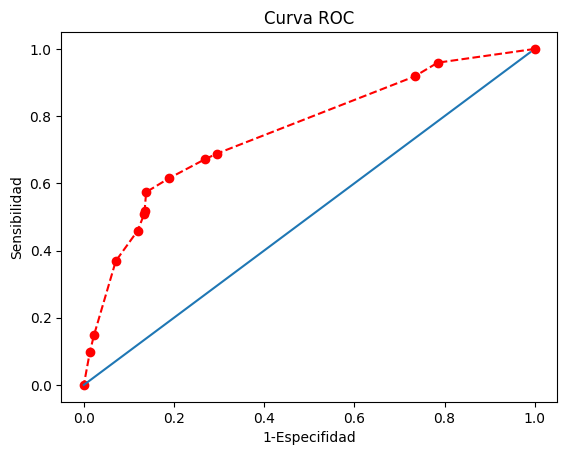

In [ ]:
%matplotlib inline
plt.plot(especifities_1, sensitivities, marker="o", linestyle="--", color="r")
x=[i*0.01 for i in range(100)]
y=[i*0.01 for i in range(100)]
plt.plot(x,y)
plt.xlabel("1-Especifidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC")

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, auc

def evaluate_model(name_model, model, X_test, y_test):

    # Realizar predicciones
    y_pred = model.predict(X_test)

    # Calcular probabilidades para el cálculo de Gini
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    auc = roc_auc_score(y_test, y_pred_proba)
    gini = 2 * auc - 1
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Crear diccionario con las métricas
    metrics = {
        'Modelo': name_model,
        'AUC': auc,
        'Gini': gini,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    }

    return metrics

In [ ]:
evaluate_model('Logistico_X_test', lm, X_test, Y_test)

{'Modelo': 'Logistico_X_test',
 'AUC': 0.7528070459428438,
 'Gini': 0.5056140918856875,
 'Accuracy': 0.8988673139158576,
 'Precision': 0.4444444444444444,
 'Recall': 0.09836065573770492,
 'F1-score': 0.1610738255033557}

El recall en el train y en el test son diferentes, el recall hace referencia a cuanto el modelo acierta al predecir los unos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict

def evaluate_binary_classifier(model, X, y, cv=5):
    """
    Evalúa un clasificador binario, muestra métricas clave y grafica la curva ROC.

    Parámetros:
    model: El modelo de clasificación a evaluar
    X: Características
    y: Etiquetas (0 o 1)
    cv: Número de folds para validación cruzada (por defecto 5)
    """

    # Obtener predicciones de probabilidad usando validación cruzada
    y_pred_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
    y_pred = y_pred_proba[:, 1] > 0.5  # Convertir probabilidades a predicciones binarias

    # Calcular la curva ROC
    fpr, tpr, _ = roc_curve(y, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y, y_pred)

    # Imprimir el informe de clasificación
    print("Informe de Clasificación:")
    print(classification_report(y, y_pred))

    # Imprimir la matriz de confusión
    print("\nMatriz de Confusión:")
    print(cm)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva Característica Operativa del Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2554
           1       0.67      0.13      0.21       329

    accuracy                           0.89      2883
   macro avg       0.78      0.56      0.58      2883
weighted avg       0.87      0.89      0.86      2883


Matriz de Confusión:
[[2533   21]
 [ 287   42]]


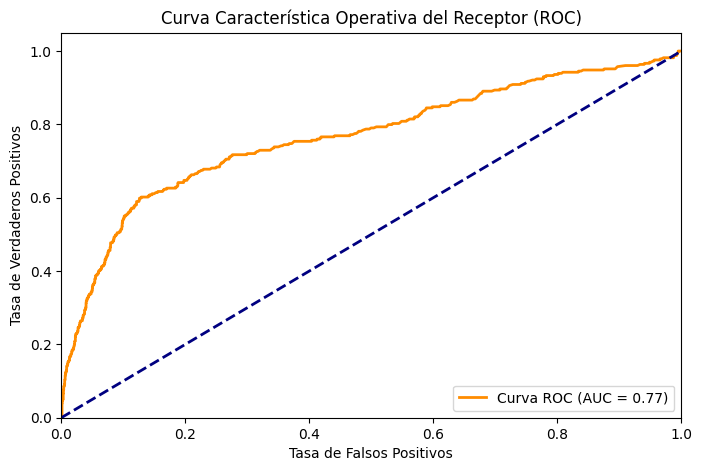


Puntuación AUC: 0.7650


In [ ]:
# Evaluar el modelo de entrenamiento
auc_score = evaluate_binary_classifier(lm, X_train, Y_train)
print(f"\nPuntuación AUC: {auc_score:.4f}")

Esto es una prueba de funcionamiento

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1114
           1       0.53      0.07      0.13       122

    accuracy                           0.90      1236
   macro avg       0.72      0.53      0.54      1236
weighted avg       0.87      0.90      0.87      1236


Matriz de Confusión:
[[1106    8]
 [ 113    9]]


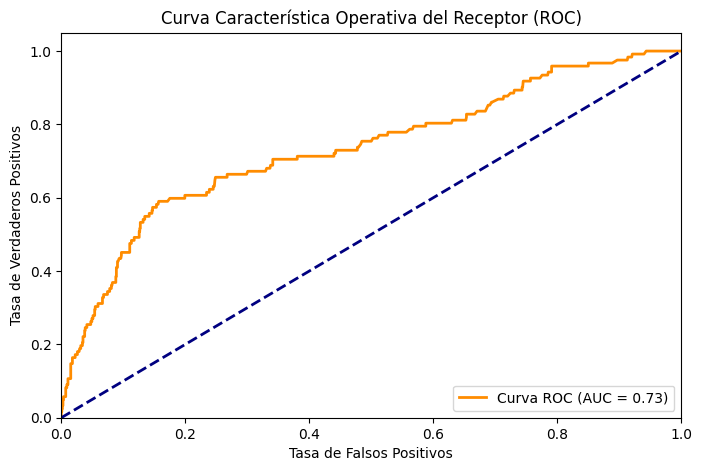


Puntuación AUC: 0.7341


In [ ]:
# Evaluar el modelo de prueba (test)
auc_score = evaluate_binary_classifier(lm, X_test, Y_test)
print(f"\nPuntuación AUC: {auc_score:.4f}")